In [3]:
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from scipy.special import softmax

In [86]:
def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def backward(policy, prob, action, state): 
    grad = np.zeros(policy.shape)
    for i in range(grad.shape[0]):
        for k in range(grad.shape[1]):
            #print('({}, {})'.format(i, k))
            if i == action:
                #print((np.exp(prob[action]*state[k]*(np.sum(np.exp(prob))-np.exp(prob[action]))))/(np.sum(np.exp(prob)))**2)
                grad[i][k] = (np.exp(prob[action]*state[k]*(np.sum(np.exp(prob))-np.exp(prob[action]))))/(np.sum(np.exp(prob)))**2
            elif i != action:
                #print(-np.exp(prob[action])*np.exp(prob[i])*state[k]/(np.sum(np.exp(prob)))**2)
                grad[i][k] = -np.exp(prob[action])*np.exp(prob[i])*state[k]/(np.sum(np.exp(prob)))**2
    return grad

In [89]:
def update_policy(policy, probs, rewards, actions, states):
    discounted_rewards = []

    for t in range(len(rewards)):
        Gt = 0 
        pw = 0
        for r in rewards[t:]:
            Gt = Gt + GAMMA**pw * r
            pw = pw + 1
        discounted_rewards.append(Gt)
        
    discounted_rewards = (discounted_rewards - np.mean(discounted_rewards)) / (np.std(discounted_rewards) + 1e-9) # normalize discounted rewards

    policy_gradient = []
    for prob, Gt, action, state in zip(probs, discounted_rewards, actions, states):
        policy_gradient.append(1/prob[action] * backward(policy, prob, action, state) * Gt)
    policy_gradient = np.sum(policy_gradient, axis = 0)
    policy += policy_gradient * learning_rate

In [90]:
GAMMA = 0.99
learning_rate = 0.003
env = gym.make('CartPole-v0')

num_actions = env.action_space.n
max_episode_num = 1500
max_steps = 10000
numsteps = []
avg_numsteps = []
all_rewards = []
policy = np.random.random_sample((env.observation_space.shape[0], env.action_space.n)).T
print(policy)

for episode in range(max_episode_num):
    state = env.reset().reshape(-1, 1)
    ps = []
    log_probs = []
    rewards = []
    actions = []
    states = []

    for steps in range(max_steps):
        #env.render()
        probs = softmax(np.dot(policy, state))
        action = np.random.choice(num_actions, p = np.squeeze(probs))
        log_prob = np.log(np.squeeze(probs)[action])
        new_state, reward, done, _ = env.step(action)
        actions.append(action)
        ps.append(np.squeeze(probs))
        states.append(np.squeeze(state))
        log_probs.append(log_prob)
        rewards.append(reward)

        if done:
            update_policy(policy, ps, rewards, actions, states)
            numsteps.append(steps)
            avg_numsteps.append(np.mean(numsteps[-10:]))
            all_rewards.append(np.sum(rewards))
            if episode % 10 == 0:
                print("episode: {}, total reward: {}, average_reward: {}, length: {}\n".format(episode, np.round(np.sum(rewards), decimals = 3),  np.round(np.mean(all_rewards[-10:]), decimals = 3), steps))
            break 
        state = new_state

[[0.96418134 0.19498469 0.89091335 0.98034319]
 [0.11058665 0.80939256 0.15229913 0.43663608]]
episode: 0, total reward: 11.0, average_reward: 11.0, length: 10

episode: 10, total reward: 11.0, average_reward: 13.3, length: 10

episode: 20, total reward: 19.0, average_reward: 15.4, length: 18

episode: 30, total reward: 12.0, average_reward: 14.2, length: 11

episode: 40, total reward: 14.0, average_reward: 14.1, length: 13

episode: 50, total reward: 9.0, average_reward: 18.2, length: 8

episode: 60, total reward: 10.0, average_reward: 16.0, length: 9

episode: 70, total reward: 12.0, average_reward: 14.9, length: 11

episode: 80, total reward: 14.0, average_reward: 15.1, length: 13

episode: 90, total reward: 13.0, average_reward: 13.4, length: 12

episode: 100, total reward: 33.0, average_reward: 16.6, length: 32

episode: 110, total reward: 9.0, average_reward: 15.8, length: 8

episode: 120, total reward: 13.0, average_reward: 18.4, length: 12

episode: 130, total reward: 17.0, ave

episode: 1190, total reward: 89.0, average_reward: 124.5, length: 88

episode: 1200, total reward: 33.0, average_reward: 121.3, length: 32

episode: 1210, total reward: 188.0, average_reward: 160.8, length: 187

episode: 1220, total reward: 149.0, average_reward: 131.4, length: 148

episode: 1230, total reward: 161.0, average_reward: 129.8, length: 160

episode: 1240, total reward: 94.0, average_reward: 116.8, length: 93

episode: 1250, total reward: 26.0, average_reward: 113.0, length: 25

episode: 1260, total reward: 149.0, average_reward: 145.2, length: 148

episode: 1270, total reward: 200.0, average_reward: 150.9, length: 199

episode: 1280, total reward: 200.0, average_reward: 152.0, length: 199

episode: 1290, total reward: 78.0, average_reward: 129.6, length: 77

episode: 1300, total reward: 144.0, average_reward: 150.6, length: 143

episode: 1310, total reward: 200.0, average_reward: 156.4, length: 199

episode: 1320, total reward: 200.0, average_reward: 168.2, length: 199

ep

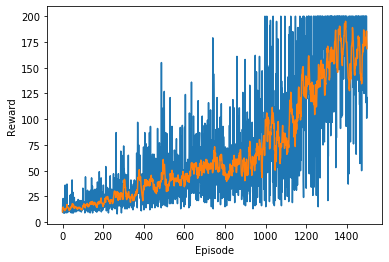

Varince of reward = 3573.531919555556


In [91]:
plt.plot(all_rewards)
plt.plot(avg_numsteps)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.show()
print('Varince of reward = {}'.format(np.var(all_rewards)))